In [1]:
import os
from dotenv import load_dotenv
from google.cloud import storage
import rasterio
from rasterio import windows
import os
import numpy as np

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.getenv("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.getenv("GOOGLE_CLOUD_KEY_PATH")

# Initialize a Google Cloud Storage client
client = storage.Client()

# Your bucket name
bucket_name = "hotspotstoplight_floodmapping"

# Create a GCS Bucket object
bucket = client.get_bucket(bucket_name)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

# Directory where you want to save the tiles
output_dir = "costa_rica_temp_outputs"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Ensure GDAL is configured to work with GCS URLs
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "YES"
os.environ["CPL_VSIL_CURL_ALLOWED_EXTENSIONS"] = "tif"

In [2]:
import os
import rasterio
import numpy as np

# Directory where the TIFF files are stored
output_dir = "costa_rica_temp_outputs"

# List all TIFF files in the directory
tiff_files = [f for f in os.listdir(output_dir) if f.endswith('.tif')]

# Initialize a list to store arrays from each TIFF file
arrays = []

# Read each TIFF file and append its array to the list
for tiff_file in tiff_files:
    tiff_path = os.path.join(output_dir, tiff_file)
    with rasterio.open(tiff_path) as src:
        # Read data from all bands
        array = src.read()
        # Append the array to the list
        arrays.append(array)

# Assuming all TIFF files have the same number of bands and dimensions,
# Determine the dimensions for preallocation based on the first array
if arrays:
    num_bands, height, width = arrays[0].shape
    num_files = len(arrays)
    # Preallocate a 4D array (num_files x num_bands x height x width)
    all_arrays = np.zeros((num_files, num_bands, height, width), dtype=arrays[0].dtype)

    # Fill the preallocated array
    for i, array in enumerate(arrays):
        all_arrays[i] = array
else:
    all_arrays = np.array([])  # No TIFF files or an empty directory

# all_arrays is now a 4D ndarray containing all your TIFF files' data


In [3]:
all_arrays.shape

(426, 16, 256, 256)

In [4]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Assuming all_arrays is your 4D ndarray from the previous step with dimensions (num_files, num_bands, height, width)
num_files, num_bands, height, width = all_arrays.shape

# Initialize an encoder
encoder = OneHotEncoder(sparse_output=False)

In [5]:
import numpy as np

# Separate band 7 into a "masks" array
masks = all_arrays[:, 6, :, :]  # Band 7 is at index 6 (0-based indexing)

# Separate band 2 and one-hot encode it
landcover_data = all_arrays[:, 1, :, :]  # Band 2 is at index 1
# Flatten landcover_data to fit the encoder's expected input shape and fit-transform
landcover_encoded = encoder.fit_transform(landcover_data.reshape(-1, 1))

# Number of classes after encoding
num_classes = landcover_encoded.shape[1]
# Reshape back to original with an additional dimension for classes
landcover_encoded_reshaped = landcover_encoded.reshape(num_files, height, width, num_classes)

# Transpose the axes of the one-hot encoded bands to match the original image bands
landcover_encoded_transposed = np.transpose(landcover_encoded_reshaped, (0, 3, 1, 2))

# Prepare "images" array with all bands except band 2 and band 7
# Filtering bands to exclude band 2 (index 1) and band 7 (index 6), and drop bands with all NaN values
images = np.concatenate([all_arrays[:, :1, :, :], all_arrays[:, 2:6, :, :], all_arrays[:, 7:, :, :]], axis=1)
# Drop bands with all NaN values across all images
images = images[:, ~np.all(np.isnan(images), axis=(0, 2, 3)), :, :]

# Now, the shape of landcover_encoded_transposed should be (num_files, num_classes, height, width)
# which can be concatenated with the original image bands

# Add the one-hot encoded band 2 data back to "images"
images = np.concatenate([images, landcover_encoded_transposed], axis=1)

print(images.shape)

(426, 24, 256, 256)


In [17]:
masks.shape

(426, 256, 256)

In [6]:
import numpy as np

def drop_all_nan_bands(data):
    """
    Drops bands that contain all NaN values from a 4D NumPy array.

    Parameters:
    - data: A 4D NumPy array of shape (samples, bands, height, width).

    Returns:
    - A 4D NumPy array with bands containing all NaN values removed.
    """
    # Check for NaNs across the height and width dimensions for each band
    # This will result in a boolean array where True indicates a band is all NaN
    is_nan_band = np.all(np.isnan(data), axis=(2, 3))

    # Use the boolean array to select bands that are not all NaN
    filtered_data = data[:, ~np.all(is_nan_band, axis=0), :, :]

    return filtered_data

In [7]:
filt_image = drop_all_nan_bands(images)

In [8]:
filt_image.shape

(426, 24, 256, 256)

In [44]:
# return the min and max values for each band, omitting NaN values
def min_max_values(data):
    """
    Returns the minimum and maximum values for each band in a 4D NumPy array,
    omitting NaN values.

    Parameters:
    - data: A 4D NumPy array of shape (samples, bands, height, width).

    Returns:
    - A tuple containing two NumPy arrays:
      - The minimum values for each band.
      - The maximum values for each band.
    """
    # Compute the minimum and maximum values for each band, ignoring NaNs
    min_values = np.nanmin(data, axis=(0, 2, 3))
    max_values = np.nanmax(data, axis=(0, 2, 3))

    return min_values, max_values

def min_max_scale(images, min_values, max_values):
    # Assuming images is a numpy array of shape (num_images, num_bands, height, width)
    num_images, num_bands, height, width = images.shape
    scaled_images = np.zeros_like(images, dtype=np.float32)
    for b in range(num_bands):  # Loop through each band
        band_min = min_values[b]
        band_max = max_values[b]
        # Avoid division by zero in case of constant band
        if band_max > band_min:
            # Scale each band individually
            scaled_images[:, b, :, :] = (images[:, b, :, :] - band_min) / (band_max - band_min)
        else:
            # If the band is constant, set it to zero (or another appropriate value)
            scaled_images[:, b, :, :] = 0
    # Clip values to ensure they are within [0, 1]
    scaled_images = np.clip(scaled_images, 0, 1)
    return scaled_images


In [45]:
# Get the min and max values for each band across all images
min_values, max_values = min_max_values(images)

# Drop bands that contain all NaN values
filt_image = drop_all_nan_bands(images)

# Perform min-max scaling across all images
scaled_data = min_max_scale(filt_image, min_values, max_values)

# Verify the shape of the scaled data
print("Scaled data shape:", scaled_data.shape)

Scaled data shape: (426, 24, 256, 256)


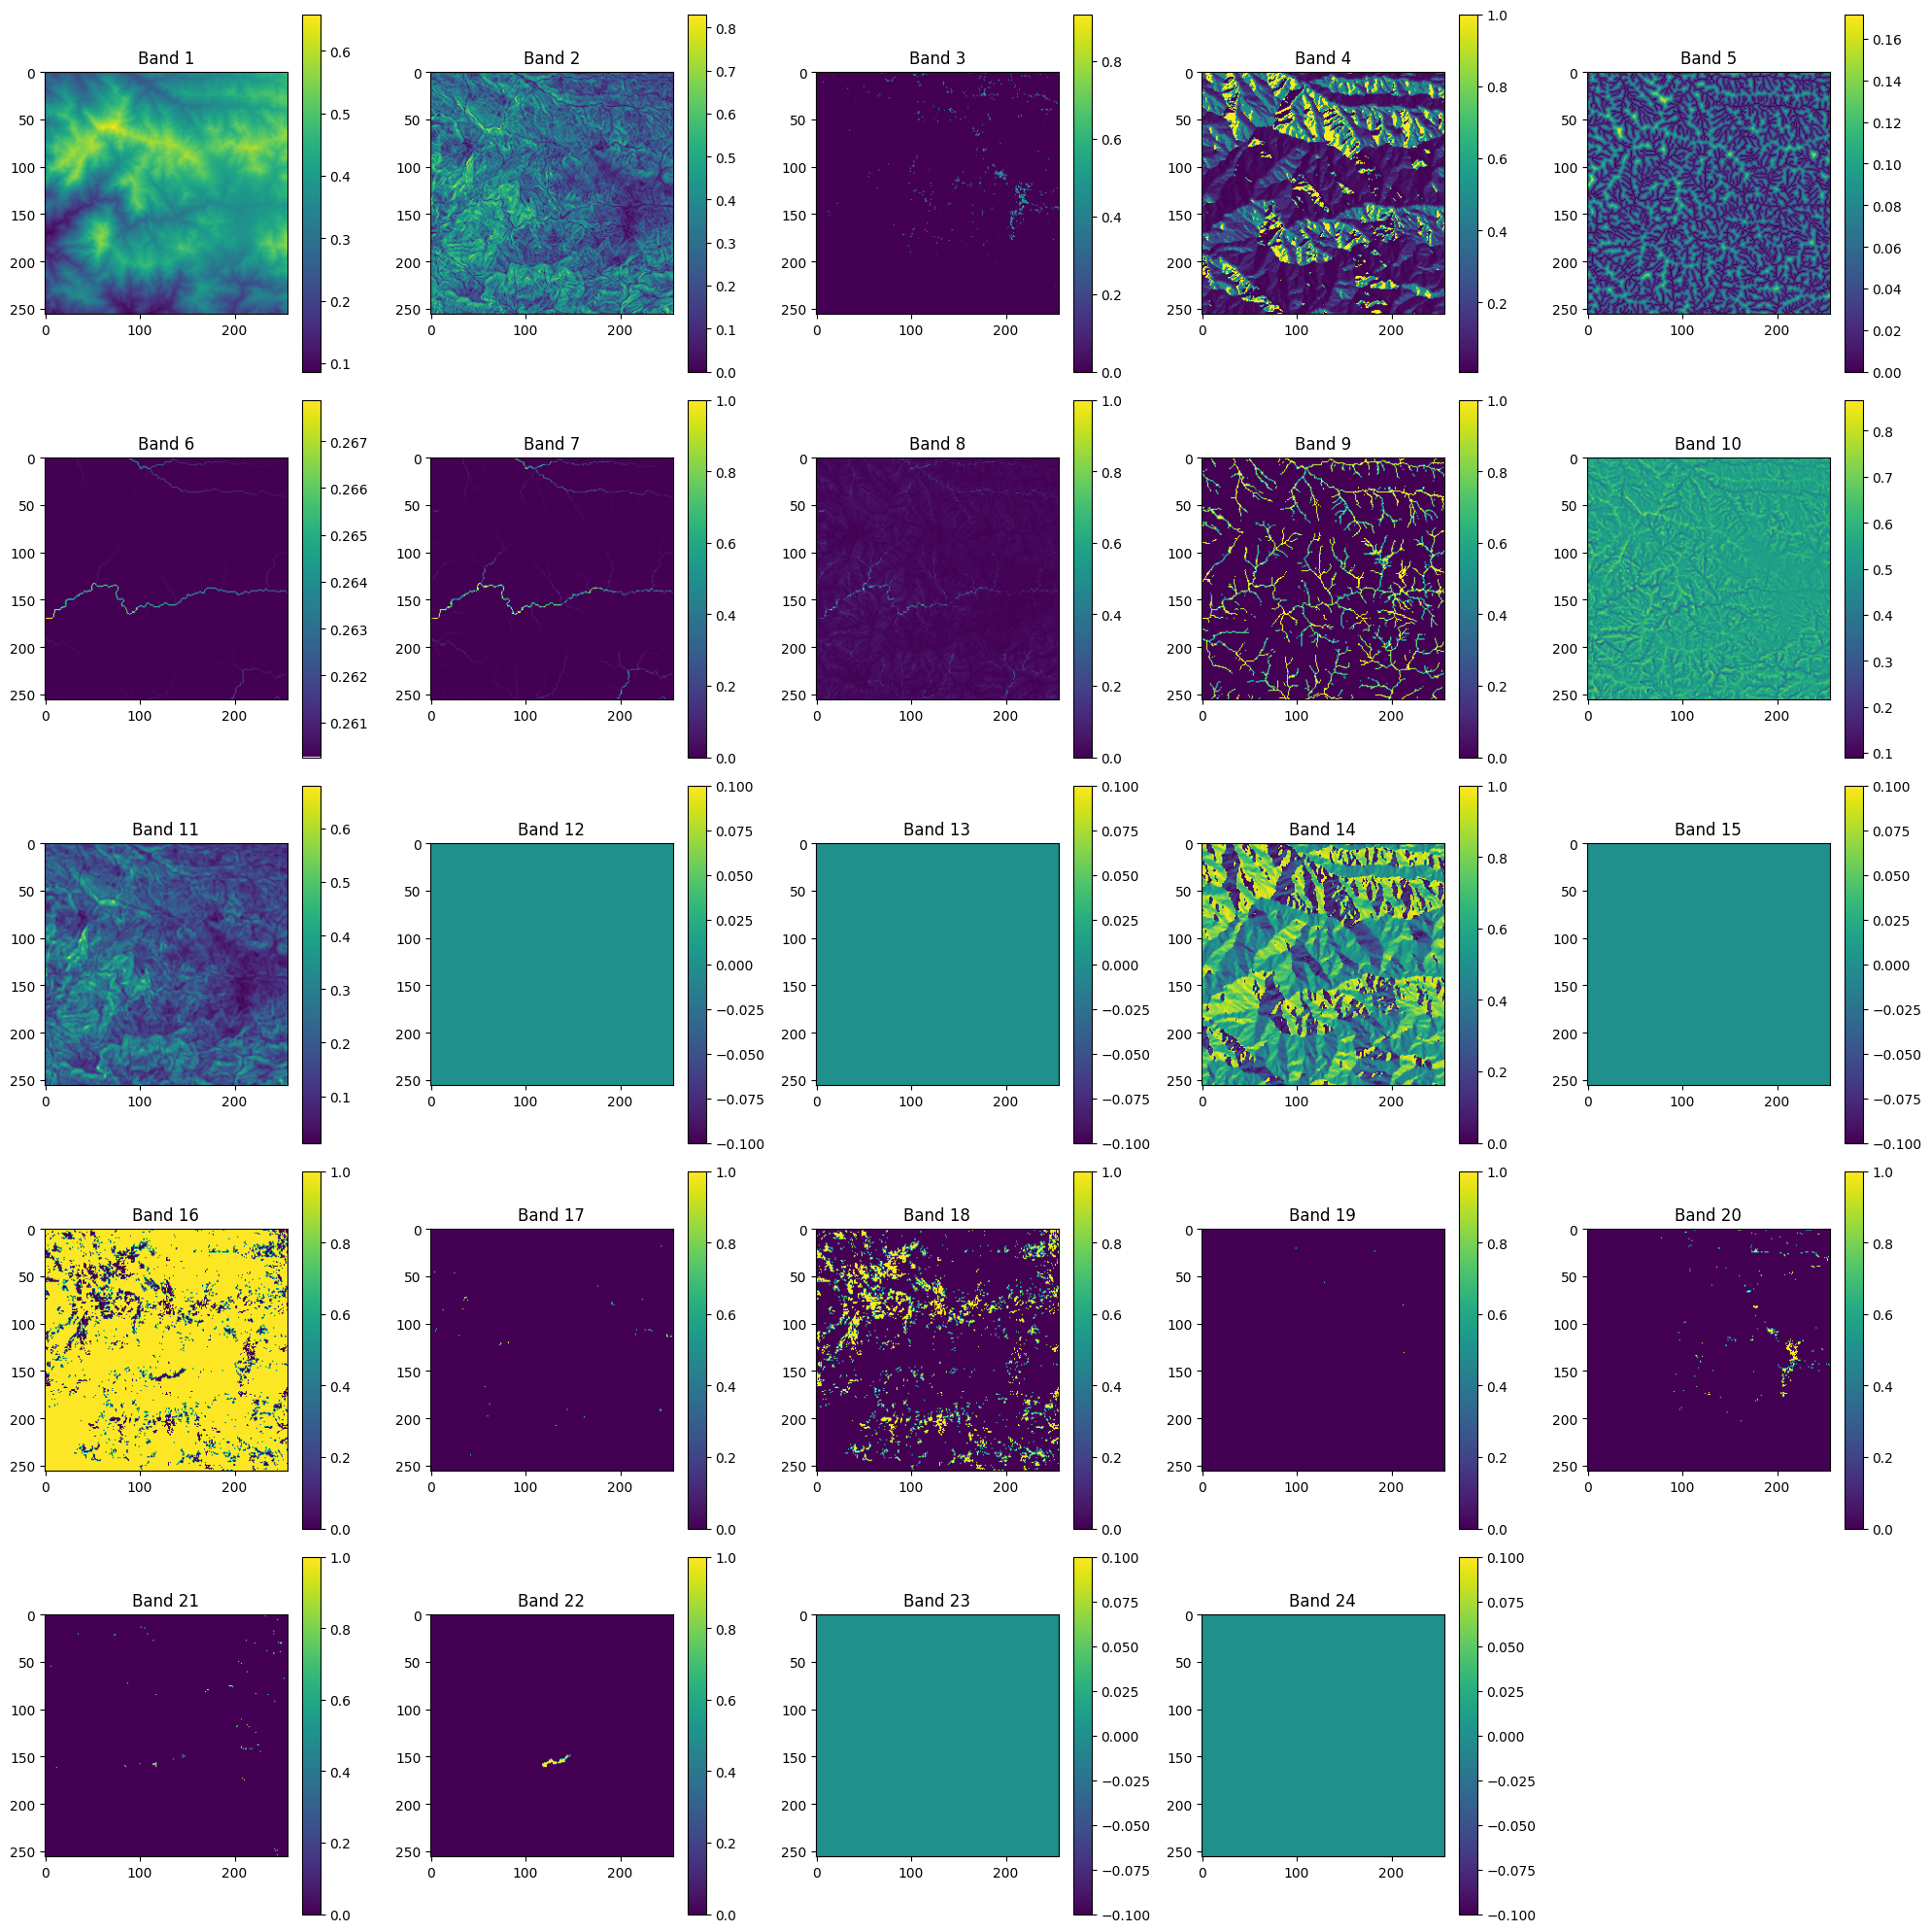

In [46]:
import matplotlib.pyplot as plt

# Assuming the shape of scaled_data is (samples, bands, height, width)
bands = scaled_data.shape[1]  # Number of bands in each image

# Calculate grid size for plots
n_cols = int(np.ceil(np.sqrt(bands)))  # Number of columns
n_rows = int(np.ceil(bands / n_cols))  # Number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Plot bands from the first image
first_image = scaled_data[100]  # Select the first image
for i in range(bands):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(first_image[i], cmap='viridis')  # Plot each band
    ax.set_title(f'Band {i+1}')
    fig.colorbar(im, ax=ax)

# If the number of subplots is not a perfect square, some subplots might be empty and can be turned off.
for i in range(bands, n_rows * n_cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

In [59]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
import keras

In [60]:
# pass my 426x24x256x256 array to a basic keras unet model for binary class segmentation of pixels
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_shape=(24, 256, 256), num_classes=1):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    
    return model

# Create a U-Net model with 24 input channels and 1 output channel
model = unet_model(input_shape=(24, 256, 256), num_classes=1)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary

model.summary()

# Assuming scaled_data is a 4D NumPy array of shape (num_images, num_bands, height, width)
num_images, num_bands, height, width = scaled_data.shape

# Reshape the data to match the input shape of the U-Net model
input_data = scaled_data.reshape(num_images, num_bands, height, width)

# Train the model
model.fit(input_data, masks, epochs=10, batch_size=4)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Scratch

In [47]:
# using poetry lighting, convert the numpy array to a tensor for training
import torch

# Convert the NumPy array to a PyTorch tensor
tensor_data = torch.tensor(scaled_data, dtype=torch.float32)

# Verify the data type and shape of the tensor
print("Tensor data type:", tensor_data.dtype)

# Verify the shape of the tensor
print("Tensor shape:", tensor_data.shape)

Tensor data type: torch.float32
Tensor shape: torch.Size([426, 24, 256, 256])


In [48]:
train_loader = torch.utils.data.DataLoader(tensor_data, batch_size=32, shuffle=True)

In [49]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [51]:
# Assuming `images` and `masks` are your numpy arrays
dataset = CustomDataset(scaled_data, masks)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [52]:
# Step 2: Defining the Model
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(24, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x
    
    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = F.binary_cross_entropy(outputs, masks)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [54]:
# Step 3: Training with PyTorch Lightning
model = SimpleCNN()

# Assuming you're using a single GPU
trainer = Trainer(max_epochs=10)
trainer.fit(model, data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
